# DynEdge Inference Result Analysis

This notebook is organized to go **from general to specific**:
- Start with a quick sanity check of the CSV contents.
- Then look at global residual distributions / calibration.
- Then move to binned resolution (W) and bias diagnostics.

All paths below are **relative** to the notebook location.


## Imports


In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0) Notes & configuration


- Energy model prediction is in log10-space.


### File paths


In [2]:
energy_test_predictions_path = Path("energy") / "test_predictions.csv"
zenith_test_predictions_path = Path("zenith") / "test_predictions.csv"
azimuth_test_predictions_path = Path("azimuth") / "test_predictions.csv"



energy_metrics_path = Path("energy") / "metrics.csv"

## 1) test_predictions.csv


### 1.a) Energy


#### Reading guide (Energy)
Recommended flow:
1) Confirm columns / NaNs / Infs.
2) Look at the global residual histogram.
3) Check residual vs true energy (trend + spread).
4) Quantify resolution with **W** (both equal-width and equal-population bins).
5) Assess bias with median residual and pred/true ratio.


In [3]:
df_energy_test_predictions = pd.read_csv(energy_test_predictions_path)


print("shape:", df_energy_test_predictions.shape)
print("columns:", list(df_energy_test_predictions.columns))

shape: (41311, 5)
columns: ['true_energy', 'pred_log10_energy', 'pred_energy', 'residual_log10', 'event_id']


In [4]:
df_energy_test_predictions["true_log10_energy"] = np.log10(df_energy_test_predictions["true_energy"].astype(float))

In [5]:
df_energy_test_predictions.head(3)

,true_energy,pred_log10_energy,pred_energy,residual_log10,event_id,true_log10_energy
0,108859.773438,3.031981,1076.417480,-2.004887,242,5.036867
1,14684.890625,4.300442,19972.949219,0.133572,778,4.166871
2,127.363152,2.352156,224.986465,0.247113,1171,2.105044


In [6]:
print("Rows:", len(df_energy_test_predictions))

print("\nNaN counts:")
print(df_energy_test_predictions[["true_energy", "pred_log10_energy","pred_energy",  "residual_log10", "event_id", "true_log10_energy" ]].isna().sum())

Rows: 41311

NaN counts:
true_energy          0
pred_log10_energy    0
pred_energy          0
residual_log10       0
event_id             0
true_log10_energy    0
dtype: int64


In [7]:
# Inf / -Inf counts in numeric columns
for col in ["true_energy", "pred_log10_energy","pred_energy",  "residual_log10", "event_id", "true_log10_energy"]:
    x = pd.to_numeric(df_energy_test_predictions[col], errors="coerce")
    print(f"\n{col}: +inf={np.isposinf(x).sum()}, -inf={np.isneginf(x).sum()}, any_inf={np.isinf(x).sum()}")


true_energy: +inf=0, -inf=0, any_inf=0

pred_log10_energy: +inf=0, -inf=0, any_inf=0

pred_energy: +inf=0, -inf=0, any_inf=0

residual_log10: +inf=0, -inf=0, any_inf=0

event_id: +inf=0, -inf=0, any_inf=0

true_log10_energy: +inf=0, -inf=0, any_inf=0


In [8]:
# true_energy <= 0 check 
true_e = pd.to_numeric(df_energy_test_predictions["true_energy"], errors="coerce")
print("\ntrue_energy <= 0:", (true_e <= 0).sum())


true_energy <= 0: 0


#### Energy overview


In [9]:
# ---- Energy: global W over the full test set ----
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)
p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
W = (p84 - p16) / 2

print(f"p16={p16:.4f}, p50={p50:.4f}, p84={p84:.4f}, W={W:.4f}")

p16=-0.3470, p50=0.0275, p84=0.3172, W=0.3321


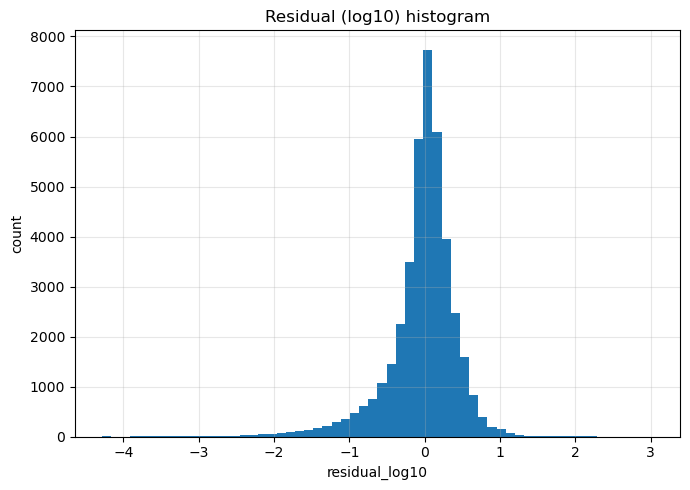

In [10]:
# ---- Energy: residual_log10 histogram (full test set) ----

plt.figure(figsize=(7, 5))
plt.hist(r, bins=60)
plt.xlabel("residual_log10")
plt.ylabel("count")
plt.title("Residual (log10) histogram")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Residual vs true energy (with binned median)

This diagnostic shows how the **log10 residual** behaves across the energy range:

- Each blue point is one event:  
  $r = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$  
- The horizontal line at $r=0$ is the **ideal** case (no bias).
- The red curve is the **binned median** of the residual, which highlights the typical trend.

What to look for:
- If the red curve stays near 0 → the model is **well-calibrated** across energies.
- If it drifts above 0 → systematic **overestimation**.
- If it drifts below 0 → systematic **underestimation**.
- If the vertical spread increases with energy → **worsening resolution** (larger event-to-event scatter).



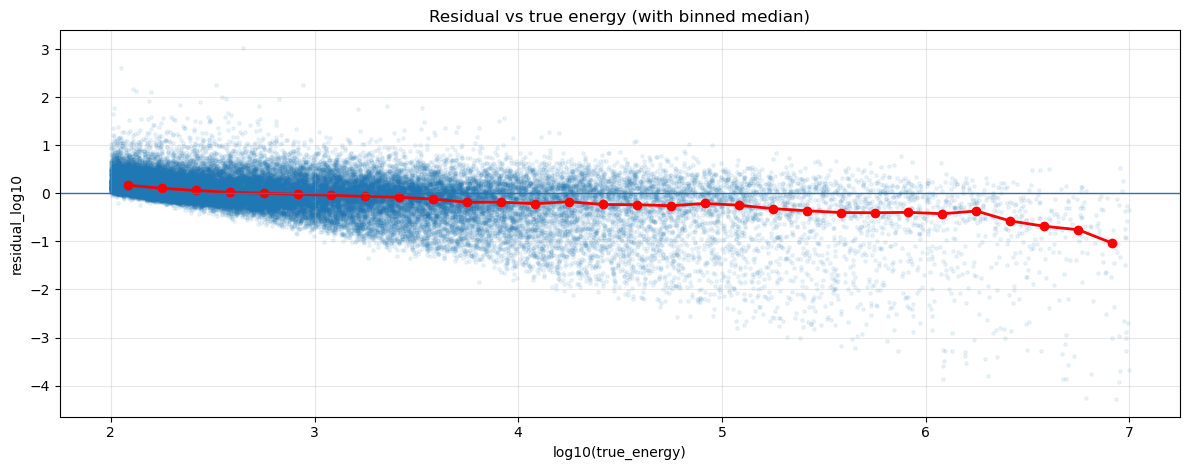

In [11]:
# ---- Energy: residual vs true_log10_energy scatter + binned median ----

x = df_energy_test_predictions["true_log10_energy"].to_numpy(dtype=float)
r = df_energy_test_predictions["residual_log10"].to_numpy(dtype=float)

# scatter (subsample to keep it fast/visible)
rng = np.random.default_rng(0)
n_show = min(60000, len(x))
idx = rng.choice(len(x), size=n_show, replace=False)

plt.figure(figsize=(12, 4.8))
plt.scatter(x[idx], r[idx], s=6, alpha=0.08)

# binned median (equal-width in x)
n_bins = 30
bins = np.linspace(x.min(), x.max(), n_bins + 1)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

median_r = []
for left, right in zip(bins[:-1], bins[1:]):
    if right == bins[-1]:
        m = (x >= left) & (x <= right)
    else:
        m = (x >= left) & (x < right)

    if np.any(m):
        median_r.append(np.median(r[m]))
    else:
        median_r.append(np.nan)

median_r = np.array(median_r, dtype=float)

# plot median curve
plt.plot(bin_centers, median_r, marker="o", linewidth=2, color = "r")

# reference line
plt.axhline(0.0, linestyle="-", linewidth=1)

plt.xlabel("log10(true_energy)")
plt.ylabel("residual_log10")
plt.title("Residual vs true energy (with binned median)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


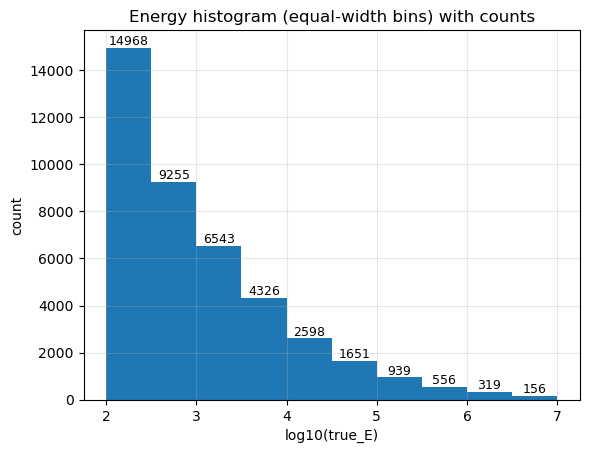

In [12]:
# ---- Energy: histogram with counts annotated on top of bars ----
n_bins_energy = 10
bins_energy = np.linspace(
    df_energy_test_predictions["true_log10_energy"].min(),
    df_energy_test_predictions["true_log10_energy"].max(),
    n_bins_energy + 1,
)
values = df_energy_test_predictions["true_log10_energy"].to_numpy()

plt.figure()
counts, edges, patches = plt.hist(values, bins=bins_energy)

# annotate each bar with its count
for c, left, right in zip(counts, edges[:-1], edges[1:]):
    if c <= 0:
        continue
    x = 0.5 * (left + right)
    plt.text(x, c, f"{int(c)}", ha="center", va="bottom", fontsize=9)

plt.xlabel("log10(true_E)")
plt.ylabel("count")
plt.title("Energy histogram (equal-width bins) with counts")
plt.grid(True, alpha=0.3)
plt.show()


In [13]:
df_energy_w_rows = []
for left, right in zip(edges[:-1], edges[1:]):
    # select events in this bin (match matplotlib hist logic: [left, right) except last bin includes right)
    if right == edges[-1]:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] <= right)
    else:
        mask = (df_energy_test_predictions["true_log10_energy"] >= left) & (df_energy_test_predictions["true_log10_energy"] < right)

    r = df_energy_test_predictions.loc[mask, "residual_log10"].to_numpy(dtype=float)

    # skip empty bins (shouldn't happen, but safe)
    if r.size == 0:
        continue

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (left + right)

    df_energy_w_rows.append({
        "Ebin": f"({left:.3f}, {right:.3f}]",
        "E_center_log10": center,
        "count": int(r.size),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table = pd.DataFrame(df_energy_w_rows)
df_energy_W_table


,Ebin,E_center_log10,count,p16,p50,p84,W
0,"(2.000, 2.500]",2.249981,14968,-0.035715,0.123847,0.389871,0.212793
1,"(2.500, 3.000]",2.749870,9255,-0.238682,0.004964,0.315503,0.277093
2,"(3.000, 3.500]",3.249758,6543,-0.483135,-0.061241,0.270746,0.376940
3,"(3.500, 4.000]",3.749646,4326,-0.715296,-0.153390,0.206191,0.460743
4,"(4.000, 4.499]",4.249534,2598,-0.999501,-0.209636,0.205782,0.602641
5,"(4.499, 4.999]",4.749422,1651,-1.190253,-0.236889,0.204971,0.697612
6,"(4.999, 5.499]",5.249311,939,-1.417254,-0.301551,0.163690,0.790472
7,"(5.499, 5.999]",5.749199,556,-1.628825,-0.402337,0.070917,0.849871
8,"(5.999, 6.499]",6.249087,319,-1.695658,-0.478368,-0.022340,0.836659
9,"(6.499, 6.999]",6.748975,156,-2.370998,-0.844405,-0.144696,1.113151


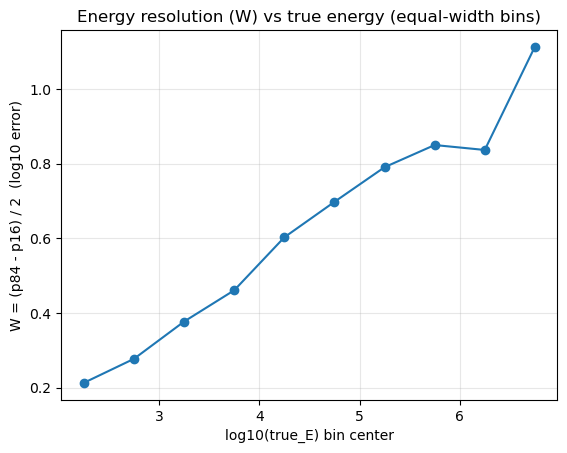

In [14]:
# ---- Energy: plot W vs true energy (equal-width bins) ----

plt.figure()
plt.plot(df_energy_W_table["E_center_log10"], df_energy_W_table["W"], marker="o")
plt.xlabel("log10(true_E) bin center")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-width bins)")
plt.grid(True, alpha=0.3)
plt.show()


### Interpreting the W trend (equal-width bins)

In the **equal-width** energy binning, the number of events per bin is **not uniform**.  
At higher energies the bins contain **much fewer events**, so the quantile estimates (p16/p50/p84) become **statistically unstable**. This can artificially inflate the width  
$W = (p84 - p16)/2$ and make it look like the resolution worsens rapidly with energy.

To reduce this sampling effect, we next repeat the same analysis using **equal-population bins** (i.e., bins with approximately the same number of events) and compare the results.


In [15]:
# ---- create equal-population bins (qcut) ----

n_qbins_energy = 10

df_energy_test_predictions["Ebin_q"] = pd.qcut(
    df_energy_test_predictions["true_log10_energy"],
    q=n_qbins_energy,
    duplicates="drop",
)


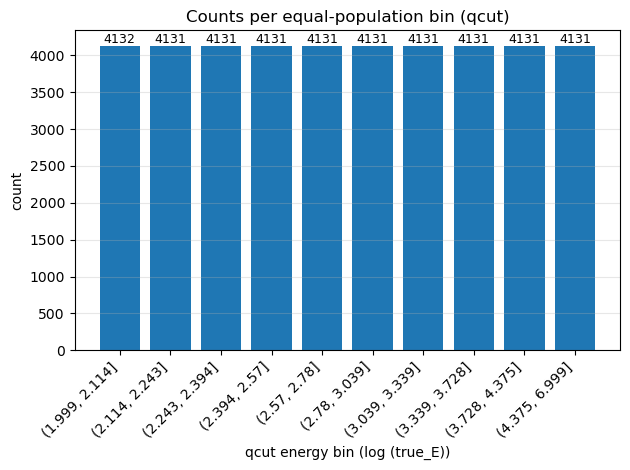

In [16]:
# ----  plot counts per qcut bin ----

bin_counts_q = df_energy_test_predictions["Ebin_q"].value_counts().sort_index()

plt.figure()
bars = plt.bar(range(len(bin_counts_q)), bin_counts_q.to_numpy())
plt.xticks(range(len(bin_counts_q)), [str(i) for i in bin_counts_q.index], rotation=45, ha="right")
plt.xlabel("qcut energy bin (log (true_E))")
plt.ylabel("count")
plt.title("Counts per equal-population bin (qcut)")
plt.grid(True, axis="y", alpha=0.3)

# annotate counts on top of bars
for i, c in enumerate(bin_counts_q.to_numpy()):
    plt.text(i, c, str(int(c)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()


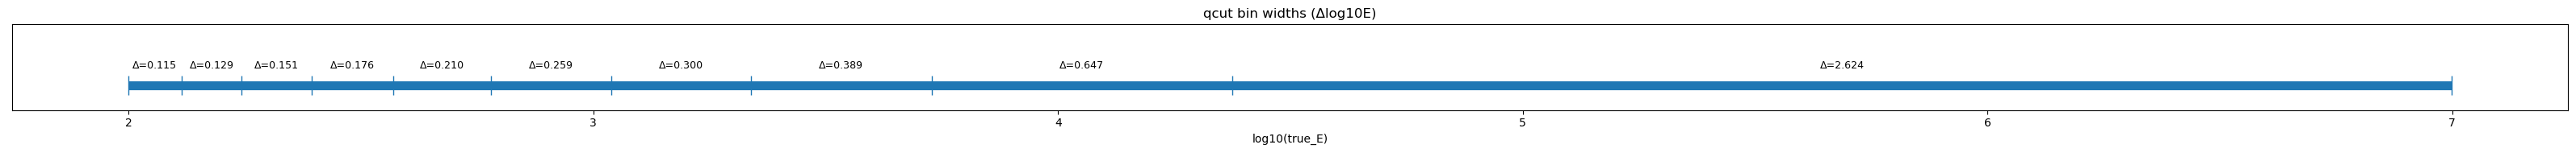

In [17]:
# ---- Visualize qcut bin widths only (in log10-space) ----

# intervals in correct order
intervals = bin_counts_q.index  # IntervalIndex from your existing bin_counts_q

lefts  = np.array([iv.left for iv in intervals], dtype=float)
rights = np.array([iv.right for iv in intervals], dtype=float)
widths = rights - lefts
centers = (lefts + rights) / 2

plt.figure(figsize=(32, 2))

# draw each bin as a horizontal segment
for L, R, w, x in zip(lefts, rights, widths, centers):
    plt.hlines(0, L, R, linewidth=8)
    plt.text(x, 0.12, f"Δ={w:.3f}", ha="center", va="bottom", fontsize=9)

# draw bin boundaries as small ticks
for x in lefts:
    plt.vlines(x, -0.08, 0.08, linewidth=1)
plt.vlines(rights[-1], -0.08, 0.08, linewidth=1)

plt.yticks([])
plt.xlabel("log10(true_E)")
plt.title("qcut bin widths (Δlog10E)")
plt.ylim(-0.2, 0.5)
plt.tight_layout()
plt.show()


In [18]:
# ---- Energy: p16/p50/p84 and W per qcut bin (use groupby directly; no remasking) ----

rows_energy_q = []
for iv, g in df_energy_test_predictions.groupby("Ebin_q", observed=True):
    r = g["residual_log10"].to_numpy(dtype=float)

    p16, p50, p84 = np.quantile(r, [0.16, 0.50, 0.84])
    W = (p84 - p16) / 2
    center = 0.5 * (float(iv.left) + float(iv.right))

    rows_energy_q.append({
        "Ebin_q": str(iv),
        "E_center_log10": center,
        "count": int(len(g)),
        "p16": p16,
        "p50": p50,
        "p84": p84,
        "W": W,
    })

df_energy_W_table_q = pd.DataFrame(rows_energy_q).sort_values("E_center_log10")
df_energy_W_table_q


,Ebin_q,E_center_log10,count,p16,p50,p84,W
0,"(1.999, 2.114]",2.0565,4132,0.056936,0.176738,0.456620,0.199842
1,"(2.114, 2.243]",2.1785,4131,-0.015462,0.129529,0.396555,0.206008
2,"(2.243, 2.394]",2.3185,4131,-0.078490,0.080982,0.343818,0.211154
3,"(2.394, 2.57]",2.4820,4131,-0.135168,0.042675,0.327606,0.231387
4,"(2.57, 2.78]",2.6750,4131,-0.212629,0.013031,0.327431,0.270030
5,"(2.78, 3.039]",2.9095,4131,-0.323910,-0.020621,0.307373,0.315642
6,"(3.039, 3.339]",3.1890,4131,-0.465011,-0.056316,0.286789,0.375900
7,"(3.339, 3.728]",3.5335,4131,-0.619430,-0.108638,0.216331,0.417880
8,"(3.728, 4.375]",4.0515,4131,-0.873468,-0.192911,0.204296,0.538882
9,"(4.375, 6.999]",5.6870,4131,-1.341285,-0.303657,0.154052,0.747669


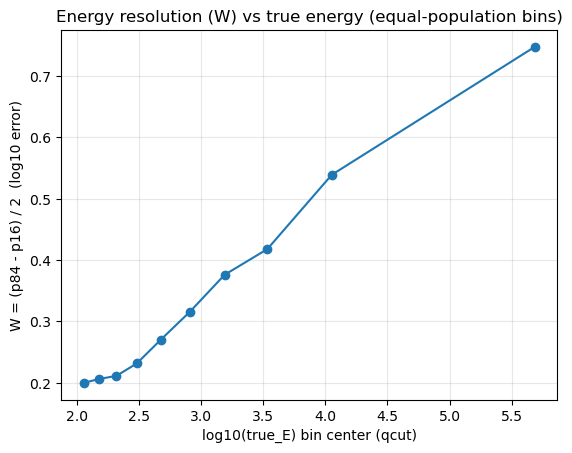

In [19]:
# ---- Energy: plot W vs true energy (qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["W"], marker="o")
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("W = (p84 - p16) / 2  (log10 error)")
plt.title("Energy resolution (W) vs true energy (equal-population bins)")
plt.grid(True, alpha=0.3)
plt.show()


## Why `residual_log10`?

I analyze the prediction error in **log10-space** using `residual_log10`.  
This is especially convenient when the energy spans many orders of magnitude.


## Definition of `residual_log10`

`residual_log10` is defined as:

$ \mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true}) $

In the CSV this corresponds to:

$ \mathrm{residual\_log10} = \mathrm{pred\_log10\_energy} - \log_{10}(\mathrm{true\_energy}) $


## Interpreting the sign of `residual_log10`

- `residual_log10 = 0` → perfect prediction  
- `residual_log10 > 0` → the model **overpredicts** energy  
- `residual_log10 < 0` → the model **underpredicts** energy


## Quantiles: p16, p50, p84

To summarize the distribution of `residual_log10`:

- **p50** = median (middle value) → can be interpreted as **bias**
- **p16** and **p84** = the 16th and 84th percentiles  
  (If the residuals were Gaussian, these would roughly correspond to **±1σ** around the median.)


## Resolution proxy: W

I define a resolution-like width using the central 68% interval:

$ W = \frac{p84 - p16}{2} $

Interpretation:
- **Small W** → tighter residual distribution → **better resolution**
- **Large W** → wider residual distribution → **worse resolution**

**Note:** W is measured in **log10-error units**, not directly in “% error”.


## Energy performance so far: resolution (W)

So far we focused on **resolution**, summarized by  
$W = (p84 - p16)/2$, computed from the `residual_log10` distribution in each energy bin.

Resolution tells us **how wide** the error distribution is.

Next, we examine **bias**:  
Does the model systematically **overestimate** or **underestimate** the energy, and does this depend on energy?


## Bias analysis — three complementary views

There are three simple and complementary ways to study bias:

1) **Median residual vs energy**  
   Plot $p50(\mathrm{residual\_log10})$ as a function of energy.  
   This is the most direct bias measure in log-space.

2) **Median pred/true ratio vs energy**  
   Convert the median residual into a multiplicative ratio  
   $\mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50}$  
   to make the bias more intuitive.

3) **Calibration scatter: predicted vs true**  
   Plot $\widehat{\log_{10}E}$ vs $\log_{10}(E_\mathrm{true})$ with the reference line $y=x$.  
   This visually shows under/overestimation across the full range.


### 1) Median residual vs energy (log-space bias)

If we define  
$\mathrm{residual\_log10} = \widehat{\log_{10}E} - \log_{10}(E_\mathrm{true})$,

then:

- $p50 \approx 0$ → unbiased in that energy region  
- $p50 > 0$ → overestimation  
- $p50 < 0$ → underestimation


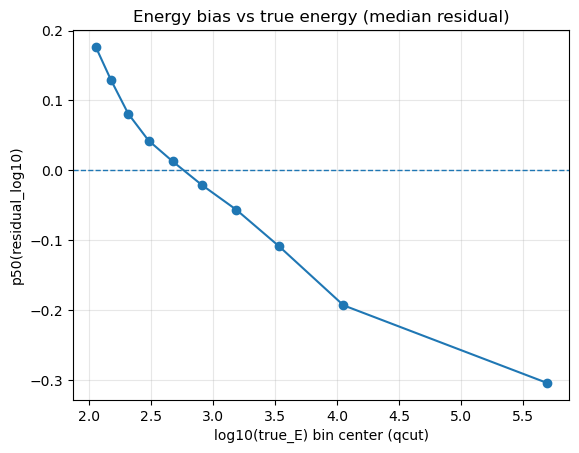

In [20]:
# ---- Energy: bias vs true energy (median residual, qcut bins) ----

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["p50"], marker="o")
plt.axhline(0.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("p50(residual_log10)")
plt.title("Energy bias vs true energy (median residual)")
plt.grid(True, alpha=0.3)
plt.show()


### 2) Median pred/true ratio vs energy (intuitive bias)

Because the residual is in log10-space, it can be converted into a multiplicative ratio:

$ \frac{E_\mathrm{pred}}{E_\mathrm{true}} = 10^{\mathrm{residual\_log10}} $

So the median bias ratio per bin is:

$ \mathrm{median}(E_\mathrm{pred}/E_\mathrm{true}) = 10^{p50} $

Interpretation:
- ratio ≈ 1 → unbiased
- ratio < 1 → underestimation
- ratio > 1 → overestimation


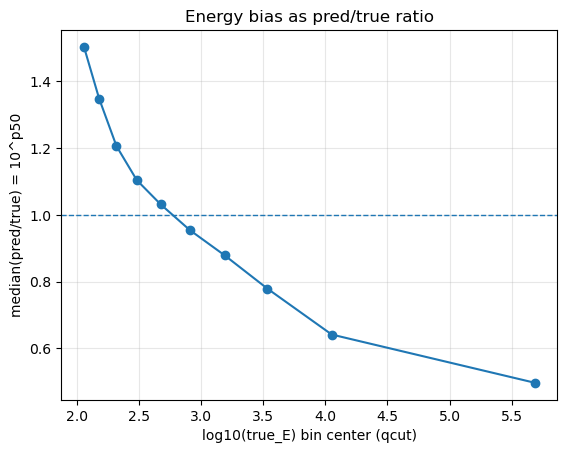

In [21]:
# ---- Energy: bias as pred/true ratio (qcut bins) ----

df_energy_W_table_q["ratio50"] = 10 ** (df_energy_W_table_q["p50"])

plt.figure()
plt.plot(df_energy_W_table_q["E_center_log10"], df_energy_W_table_q["ratio50"], marker="o")
plt.axhline(1.0, linestyle="--", linewidth=1)
plt.xlabel("log10(true_E) bin center (qcut)")
plt.ylabel("median(pred/true) = 10^p50")
plt.title("Energy bias as pred/true ratio")
plt.grid(True, alpha=0.3)
plt.show()


### 3) Calibration scatter (predicted vs true)

A calibration plot compares the model prediction to the truth directly:

- x-axis: $\log_{10}(E_\mathrm{true})$  
- y-axis: $\widehat{\log_{10}E}$

The reference line $y=x$ corresponds to perfect calibration.
Points below the line indicate underestimation; above the line indicate overestimation.


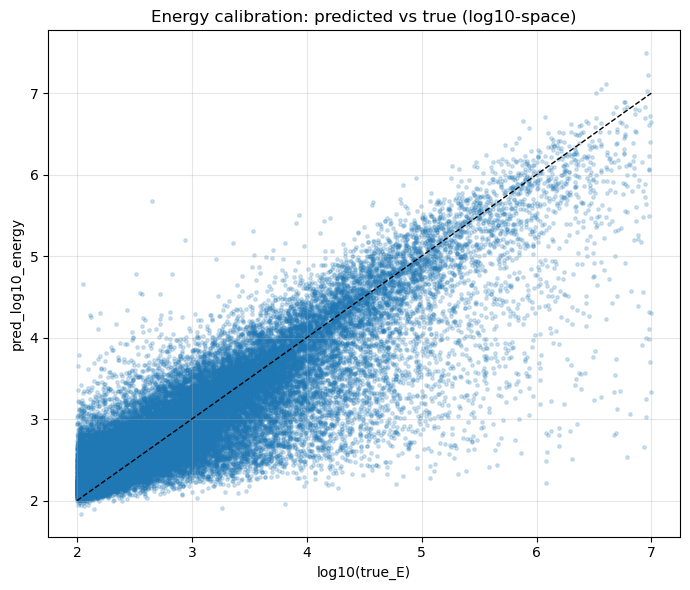

In [22]:
# ---- Energy: calibration scatter (pred_log10 vs true_log10) ----

plt.figure(figsize=(7, 6))  # bigger figure

plt.scatter(
    df_energy_test_predictions["true_log10_energy"],
    df_energy_test_predictions["pred_log10_energy"],
    s=6, alpha=0.2
)

xmin = df_energy_test_predictions["true_log10_energy"].min()
xmax = df_energy_test_predictions["true_log10_energy"].max()

plt.plot([xmin, xmax], [xmin, xmax], color="black", linestyle="--", linewidth=1)  # y=x in black

plt.xlabel("log10(true_E)")
plt.ylabel("pred_log10_energy")
plt.title("Energy calibration: predicted vs true (log10-space)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 1.b) Zenith

*(Add your zenith analysis here. Keep this section intentionally minimal for now.)*


### 1.c) Azimuth

*(Add your azimuth analysis here. Keep this section intentionally minimal for now.)*


## 2) metrics.csv


### Energy

Train/validation loss curves from `metrics.csv`.


In [25]:
df_energy_metrics = pd.read_csv(energy_metrics_path)




print("shape:", df_energy_metrics.shape)
print("columns:", list(df_energy_metrics.columns))

shape: (30, 3)
columns: ['epoch', 'train_loss', 'val_loss']


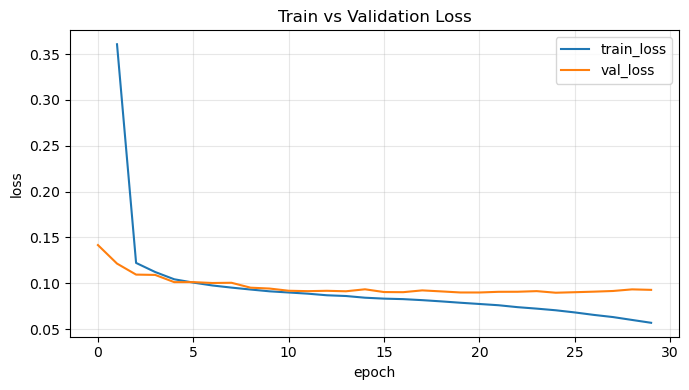

In [26]:
plt.figure(figsize=(7,4))
plt.plot(df_energy_metrics["epoch"], df_energy_metrics["train_loss"], label="train_loss")
plt.plot(df_energy_metrics["epoch"], df_energy_metrics["val_loss"], label="val_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Train vs Validation Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Zenith

*(Heading only — fill in later.)*


### Azimuth

*(Heading only — fill in later.)*


## 3) resources_and_time.csv


### Energy

*(Optional: add runtime / GPU/CPU resource plots here.)*


### Zenith

*(Heading only — fill in later.)*


### Azimuth

*(Heading only — fill in later.)*


## Appendix: Moved scratch / placeholder cells (kept unchanged)

This section contains the original empty cells / duplicate headings / early drafts.
They are kept to ensure **nothing is removed**, but moved out of the main flow.


### 1.b) Zenith (scratch / moved to Appendix)


In [23]:
df_zenith_test_predictions = pd.read_csv(zenith_test_predictions_path)

print("shape:", df_zenith_test_predictions.shape)
print("columns:", list(df_zenith_test_predictions.columns))


shape: (41311, 5)
columns: ['true_zenith', 'pred_zenith', 'abs_error_deg', 'kappa', 'event_id']


In [24]:
df_zenith_test_predictions.head(3)

,true_zenith,pred_zenith,abs_error_deg,kappa,event_id
0,0.390769,1.113049,41.383644,8.293178,242
1,1.441897,1.440086,0.103778,99.067955,778
2,1.758793,1.744501,0.818919,89.692795,1171


### Zenith (duplicate section — moved to Appendix)


#### test_predictions.csv


#### resources_and_time.csv


#### metrics.csv


### Azimuth (duplicate section — moved to Appendix)


#### test_predictions.csv


#### resources_and_time.csv


#### metrics.csv
